Let's test out naive Bayes.
I'm using MyPymatgen virtual environment with the old MP API

In [1]:
#first some libraries
import pandas as pd
from pymatgen.ext.matproj import MPRester
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import matplotlib.gridspec as gridspec

In [2]:
filename = r'G:\My Drive\teaching\5540-6640 Materials Informatics\old_apikey.txt'

def get_file_contents(filename):
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)


Sparks_API = get_file_contents(filename)

Now lets grab some data. We'll pick stable metals and stable insulators and collect their density, formation energy, volume, and formulae. 

In [3]:
mpr = MPRester(Sparks_API)

# grab some props for stable insulators
criteria = {'e_above_hull': {'$lte': 0.02},'band_gap':{'$gt':0}}

props = ['pretty_formula', 'band_gap', "density",
         'formation_energy_per_atom', 'volume']
entries = mpr.query(criteria=criteria, properties=props)

df_insulators = pd.DataFrame(entries)

print(df_insulators['density'].mean())
print(df_insulators['density'].std())

# grab some props for stable metals
criteria = {'e_above_hull': {'$lte': 0.02},'band_gap':{'$eq':0}}

props = ['pretty_formula', 'band_gap', "density",
         'formation_energy_per_atom', 'volume']
entries = mpr.query(criteria=criteria, properties=props)

df_metals = pd.DataFrame(entries)

print(df_metals['density'].mean())
print(df_metals['density'].std())

c:\Users\taylo\miniconda3\envs\MyPymatgen\lib\site-packages\pymatgen\ext\matproj_legacy.py:164: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(
100%|██████████| 28257/28257 [00:23<00:00, 1179.40it/s]


4.412158172227052
1.7255561840252907


100%|██████████| 23935/23935 [00:16<00:00, 1412.36it/s]

7.938371635988194
2.914909290913259


Now let's plot our data as probability distribution functions

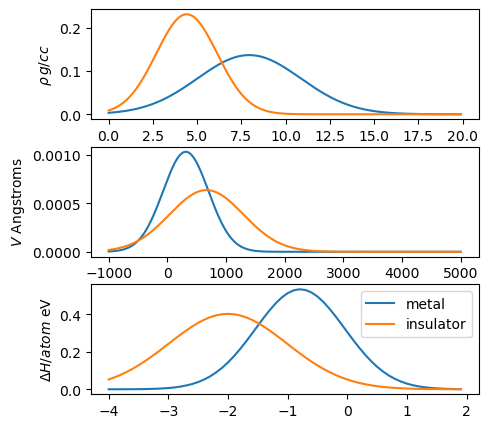

In [4]:
#let's plot our gaussians
fig = plt.figure(1, figsize=(5,5))
gs = gridspec.GridSpec(3,1)
gs.update(wspace=0.2, hspace=0.25)

#Generate first panel
xtr_subsplot= fig.add_subplot(gs[0:1,0:1])
x=np.arange(0,20,0.1)
#y=scipy.stats.norm(4.4, 1.72).cdf(x) #cumulative distribution function
y_metals=scipy.stats.norm(df_metals['density'].mean(), df_metals['density'].std()).pdf(x) #probability distribution function
y_ins=scipy.stats.norm(df_insulators['density'].mean(), df_insulators['density'].std()).pdf(x) #probability distribution function
plt.plot(x,y_metals)
plt.plot(x,y_ins)
plt.ylabel(r'$\rho\,g/cc$')

#Generate second panel
xtr_subsplot= fig.add_subplot(gs[1:2,0:1])
x=np.arange(-1000,5000,0.1)
#y=scipy.stats.norm(4.4, 1.72).cdf(x) #cumulative distribution function
y_metals=scipy.stats.norm(df_metals['volume'].mean(), df_metals['volume'].std()).pdf(x) #probability distribution function
y_ins=scipy.stats.norm(df_insulators['volume'].mean(), df_insulators['volume'].std()).pdf(x) #probability distribution function
plt.plot(x,y_metals)
plt.plot(x,y_ins)
plt.ylabel('$V$ Angstroms')

#Generate third panel
xtr_subsplot= fig.add_subplot(gs[2:3,0:1])
x=np.arange(-4,2,0.1)
#y=scipy.stats.norm(4.4, 1.72).cdf(x) #cumulative distribution function
y_metals=scipy.stats.norm(df_metals['formation_energy_per_atom'].mean(), df_metals['formation_energy_per_atom'].std()).pdf(x) #probability distribution function
y_ins=scipy.stats.norm(df_insulators['formation_energy_per_atom'].mean(), df_insulators['formation_energy_per_atom'].std()).pdf(x) #probability distribution function
plt.plot(x,y_metals,label='metal')
plt.plot(x,y_ins,label='insulator')
plt.ylabel('$\Delta H/atom$ eV')

plt.legend()

Now let's introduce a new mystery material

In [6]:
density = 4
volume = 800
formation_energy = -2
#is it a metal or insulator???

We do classification by adding up probabilities for each

In [8]:
#initial guess based on proportion of metals v insulators
prior_metals = df_metals['density'].count()/(df_insulators['density'].count()+df_metals['density'].count())
prior_insulators = 1-prior_metals
print('first guess based on metal vs insulator proportion.')
print('probability of being metal:',prior_metals)

#now probability based on density
density_metals = scipy.stats.norm(df_metals['density'].mean(), df_metals['density'].std()).pdf(density)
density_insulators = scipy.stats.norm(df_insulators['density'].mean(), df_insulators['density'].std()).pdf(density)
print('second guess based on density.')
print('density likelihood for metal:',density_metals)
print('density likelihood for insulator:',density_insulators)

#now probability based on volume
volume_metals = scipy.stats.norm(df_metals['volume'].mean(), df_metals['volume'].std()).pdf(volume)
volume_insulators = scipy.stats.norm(df_insulators['volume'].mean(), df_insulators['volume'].std()).pdf(volume)
print('third guess based on volume.')
print('volume likelihood for metal:',volume_metals)
print('volume likelihood for insulator:',volume_insulators)

#now probability based on formation energy
energy_metals = scipy.stats.norm(df_metals['formation_energy_per_atom'].mean(), df_metals['formation_energy_per_atom'].std()).pdf(formation_energy)
energy_insulators = scipy.stats.norm(df_insulators['formation_energy_per_atom'].mean(), df_insulators['formation_energy_per_atom'].std()).pdf(formation_energy)
print('fourth guess based on formation energy.')
print('energy likelihood for metal:',energy_metals)
print('energy likelihood for insulator:',energy_insulators)

#now we add up the log of these probabilities and compare
odds_of_metal = np.log(prior_metals)+np.log(density_metals)+np.log(volume_metals)+np.log(energy_metals)
odds_of_insulator = np.log(prior_insulators)+np.log(density_insulators)+np.log(volume_insulators)+np.log(energy_insulators)
print('our final guess is based on all of these probabilities combined!')
print('the odds of being a metal are:',odds_of_metal)
print('the odds of being an insulator are:',odds_of_insulator)
if odds_of_metal > odds_of_insulator:
    print('new material is probably a metal!')
else:
    print('new material is an insulator!')

first guess based on metal vs insulator proportion.
probability of being metal: 0.4585951870018394
second guess based on density.
density likelihood for metal: 0.054939081823763
density likelihood for insulator: 0.22469443307285475
third guess based on volume.
volume likelihood for metal: 0.0004685132695462034
volume likelihood for insulator: 0.0006216486250273478
fourth guess based on formation energy.
energy likelihood for metal: 0.14403029891397418
energy likelihood for insulator: 0.40339491111575754
our final guess is based on all of these probabilities combined!
the odds of being a metal are: -13.284795440023869
the odds of being an insulator are: -10.397576691863408
new material is an insulator!
